In [32]:

def plot_rt(result_df, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result_df['ML'].index.get_level_values('date')
    start_date = index[0] - pd.Timedelta(days=1)
    values = result_df['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result_df['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result_df['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=start_date,
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=-1)
    
    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(start_date, result_df.index.get_level_values('date')[-1]+pd.Timedelta(days=1))

In [33]:

def highest_density_interval(pmf, p=.9):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    if (lows.size == 0) or (highs.size == 0):
    
        return pd.Series([np.nan, np.nan], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'], dtype='float64')
    
    else:
        
        # Find the smallest range (highest density)
        best = (highs - lows).argmin()

        low = pmf.index[lows[best]]
        high = pmf.index[highs[best]]

        return pd.Series([low, high],
                         index=[f'Low_{p*100:.0f}',
                                f'High_{p*100:.0f}'])

In [54]:

import re
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from scipy.interpolate import interp1d
from matplotlib.dates import date2num
from matplotlib import dates as mdates
from matplotlib import ticker
%run ../../load_magic/storage.py
%run ../../load_magic/charts.py
s = Storage()

final_results = s.load_object('final_results')
FACEBOOK_ASPECT_RATIO = 1.91
TWITTER_ASPECT_RATIO = 16/9
def show_one_state(state_name):
    mask_series = (final_results.index.get_level_values('state') == state_name)
    result_df = final_results[mask_series]
    if result_df.shape[0] >= 2:
        fig, ax = plt.subplots(figsize=(18, 18/FACEBOOK_ASPECT_RATIO))
        plot_rt(result_df, ax, state_name)
        title = f"Real-time $R_t$ for {state_name} as of {result_df.index[-1][1].strftime('%B %d')}"
        ax.set_title(title)
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.set_ylabel('Real-time Reproductive Number ($R_t$)')

        # Instantiate a second axes that shares the same x-axis
        if 'DuFI' in result_df.columns:
            ax2 = ax.twinx()
            
            color = 'tab:blue'
            ax2.set_ylabel('Years Until Herd Immunity (at present infection rate)', color=color)
            index = result_df.DuFI.index.get_level_values('date')
            max_dufi = result_df.DuFI.max()/365
            min_dufi = result_df.DuFI.min()/365
            # NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
            #values = 4.5*result_df.DuFI.values/max_dufi
            values = (((result_df.DuFI.values/365 - min_dufi) * (4.5 - 2.0)) / (max_dufi - min_dufi)) + 2.0

            # Plot line
            ax2.plot(index, values, c=color, zorder=4, alpha=.25)
            ax2.tick_params(axis='y', labelcolor=color)
            #ax2.set_yticklabels([f'{n:,}' for n in (max_dufi*ax2.get_yticks()/4.5).astype(int)])
            ax2.set_yticklabels([f'{n:,}' for n in ((ax2.get_yticks() - 2.0)*(max_dufi - min_dufi)/(4.5 - 2.0) - min_dufi).astype(int)])

        legend_obj = ax.legend()
        fig.set_facecolor('w')
        fig.tight_layout()

        file_name = re.sub('[^A-Za-z]+', ' ', title).strip().replace(' ', '_')
        save_fig_as_various(fig, file_name, verbose=True)

Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\pgf\Real_time_R_t_for_AZ_as_of_July.pgf
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\png\Real_time_R_t_for_AZ_as_of_July.png
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\svg\Real_time_R_t_for_AZ_as_of_July.svg


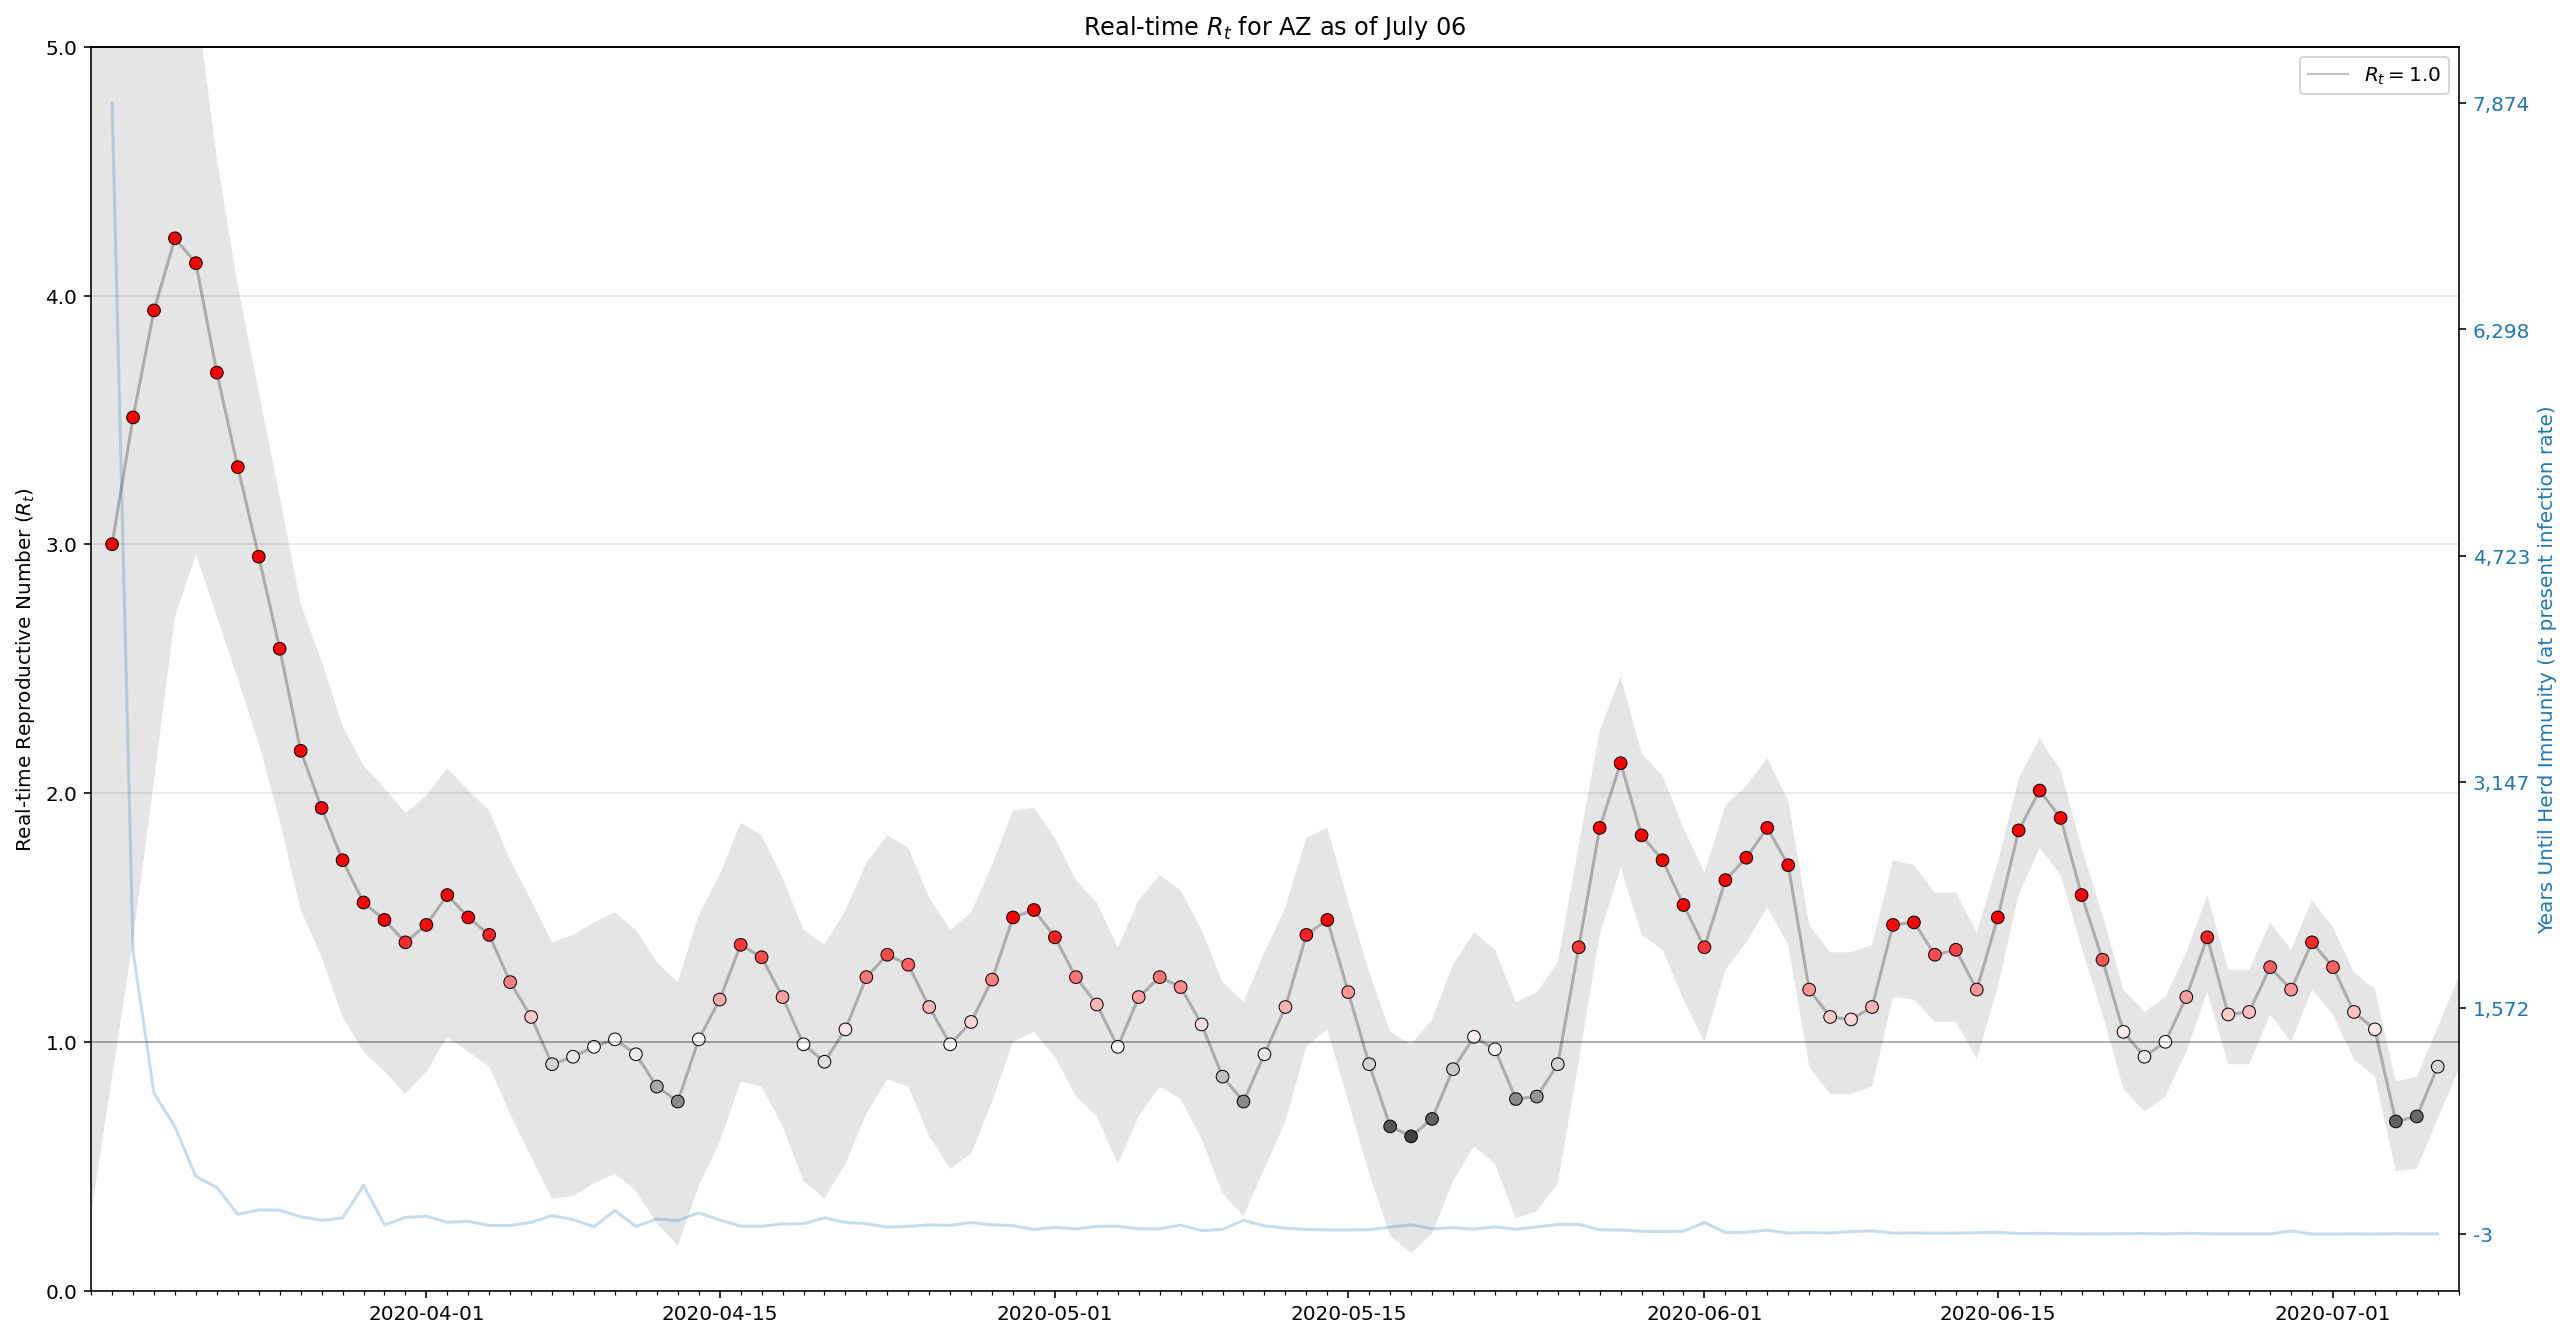

In [55]:

try:
    show_one_state(final_results.groupby('state').DuFI.min().idxmin())
except Exception as e:
    message = str(e).strip()
    print(message)

Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\pgf\Real_time_R_t_for_HI_as_of_July.pgf
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\png\Real_time_R_t_for_HI_as_of_July.png
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\svg\Real_time_R_t_for_HI_as_of_July.svg


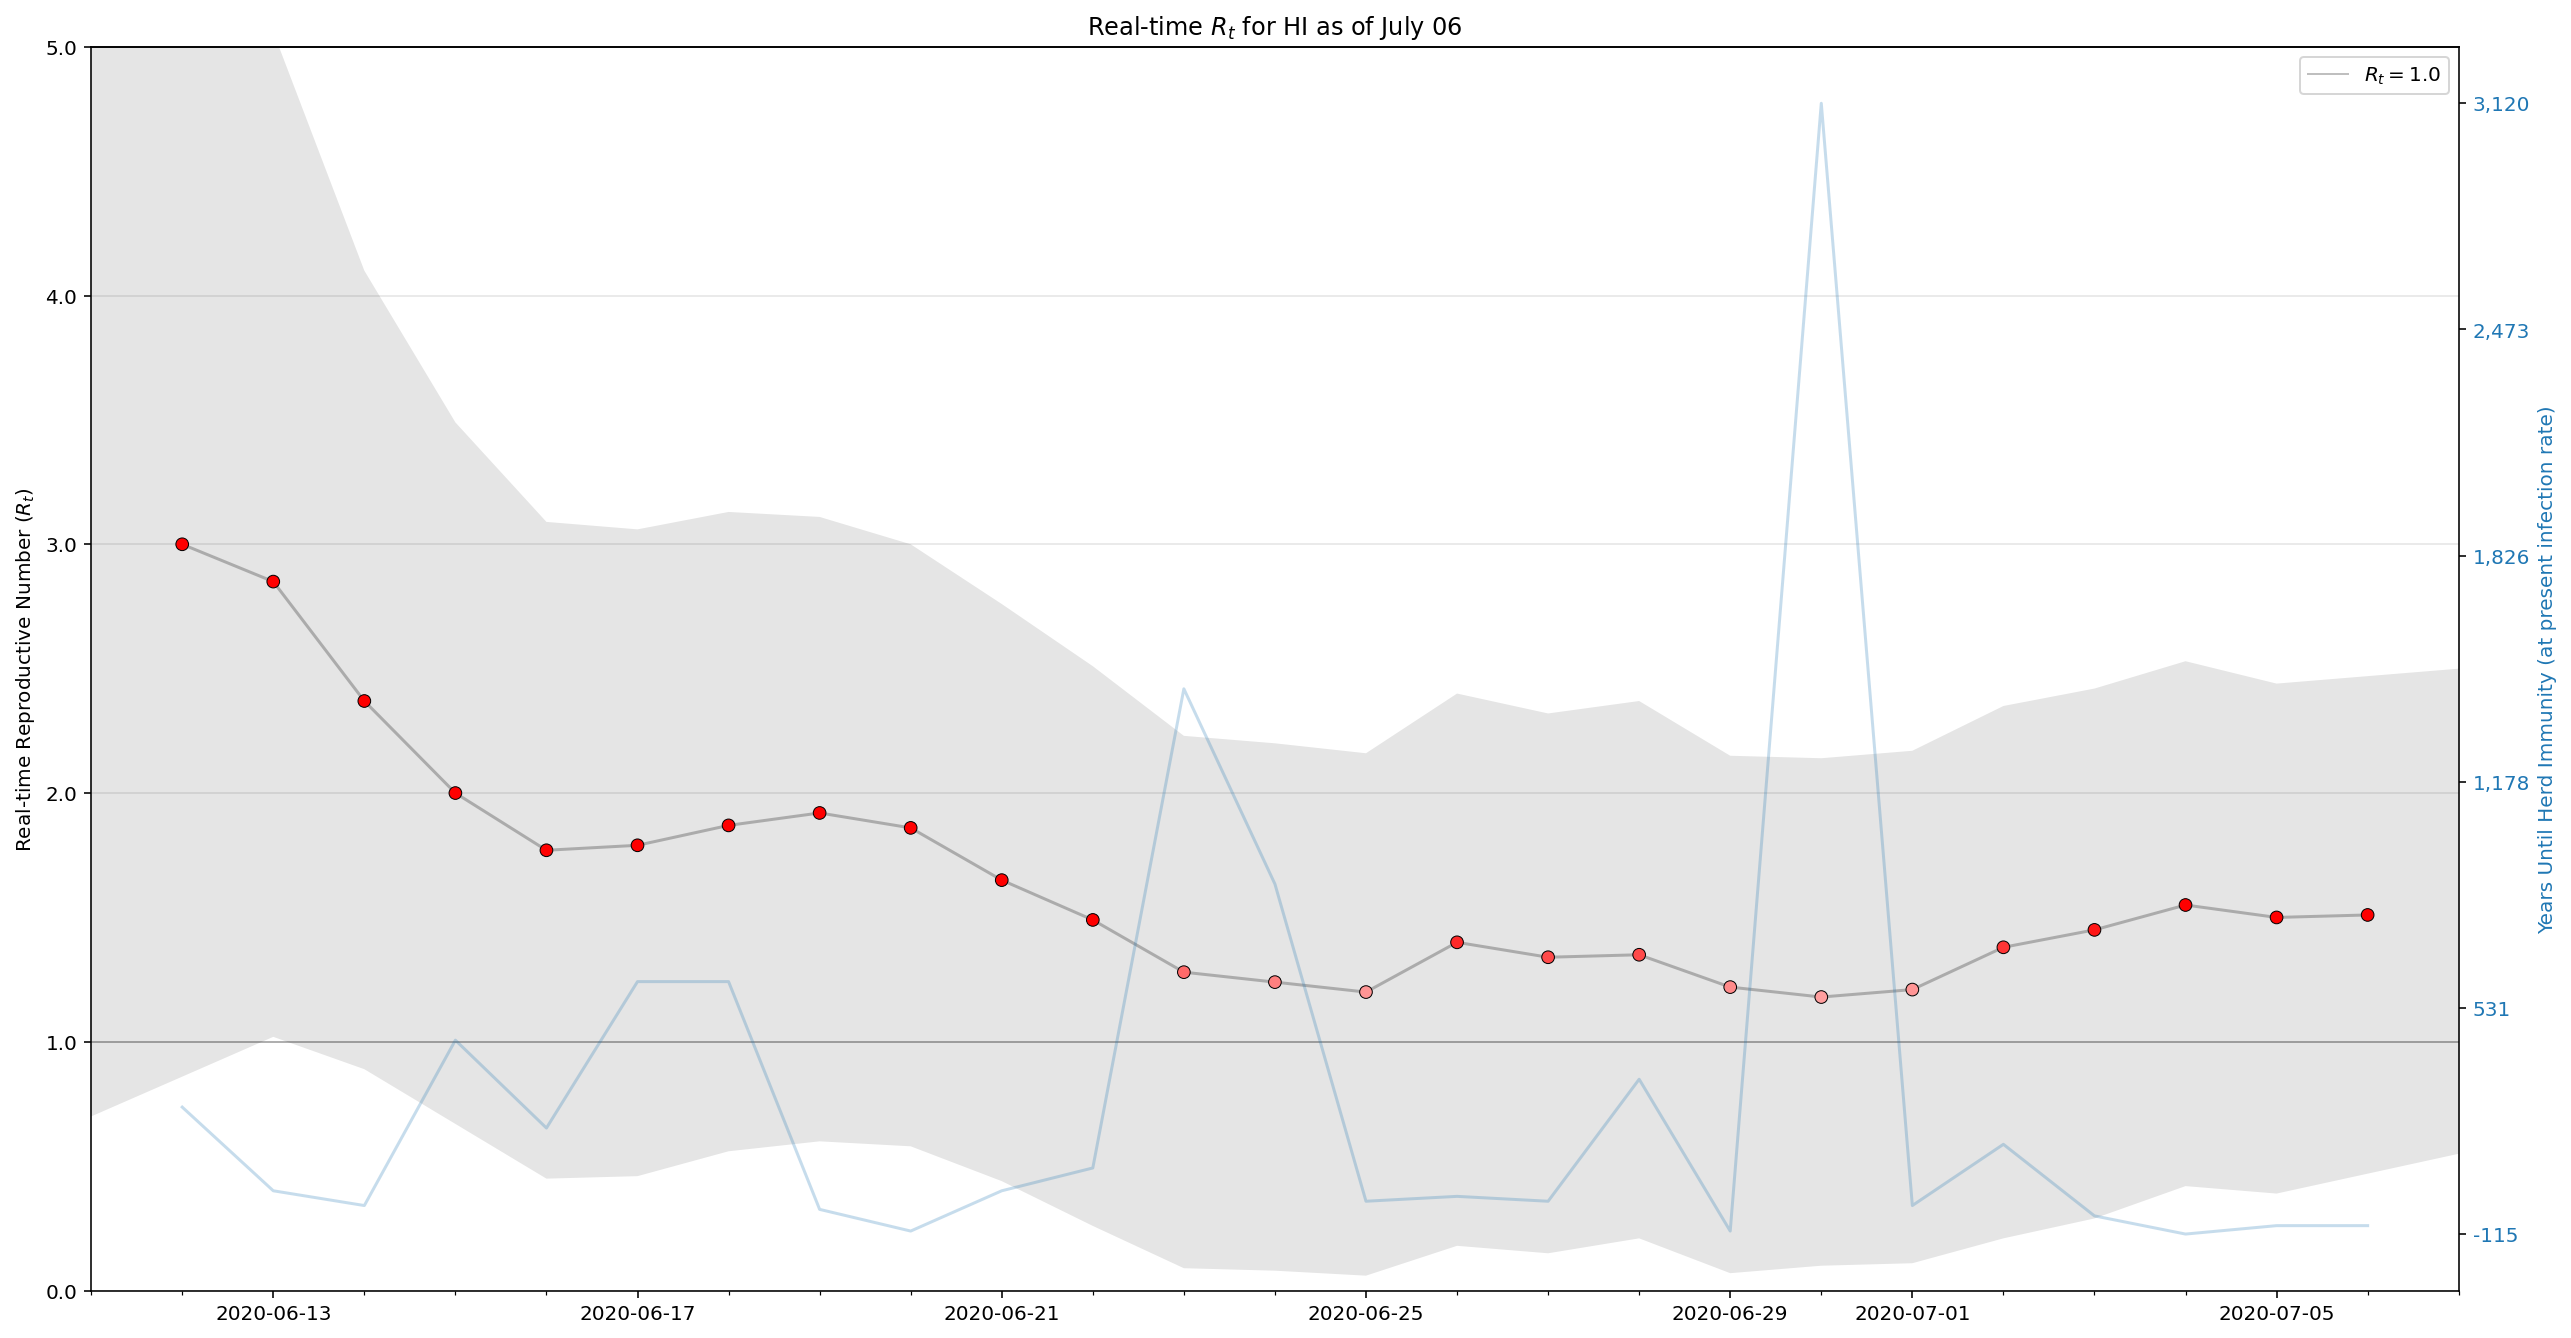

In [56]:

try:
    show_one_state(final_results.groupby('state').DuFI.min().idxmax())
except Exception as e:
    message = str(e).strip()
    print(message)

Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\pgf\Real_time_R_t_for_MA_as_of_July.pgf
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\png\Real_time_R_t_for_MA_as_of_July.png
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\svg\Real_time_R_t_for_MA_as_of_July.svg


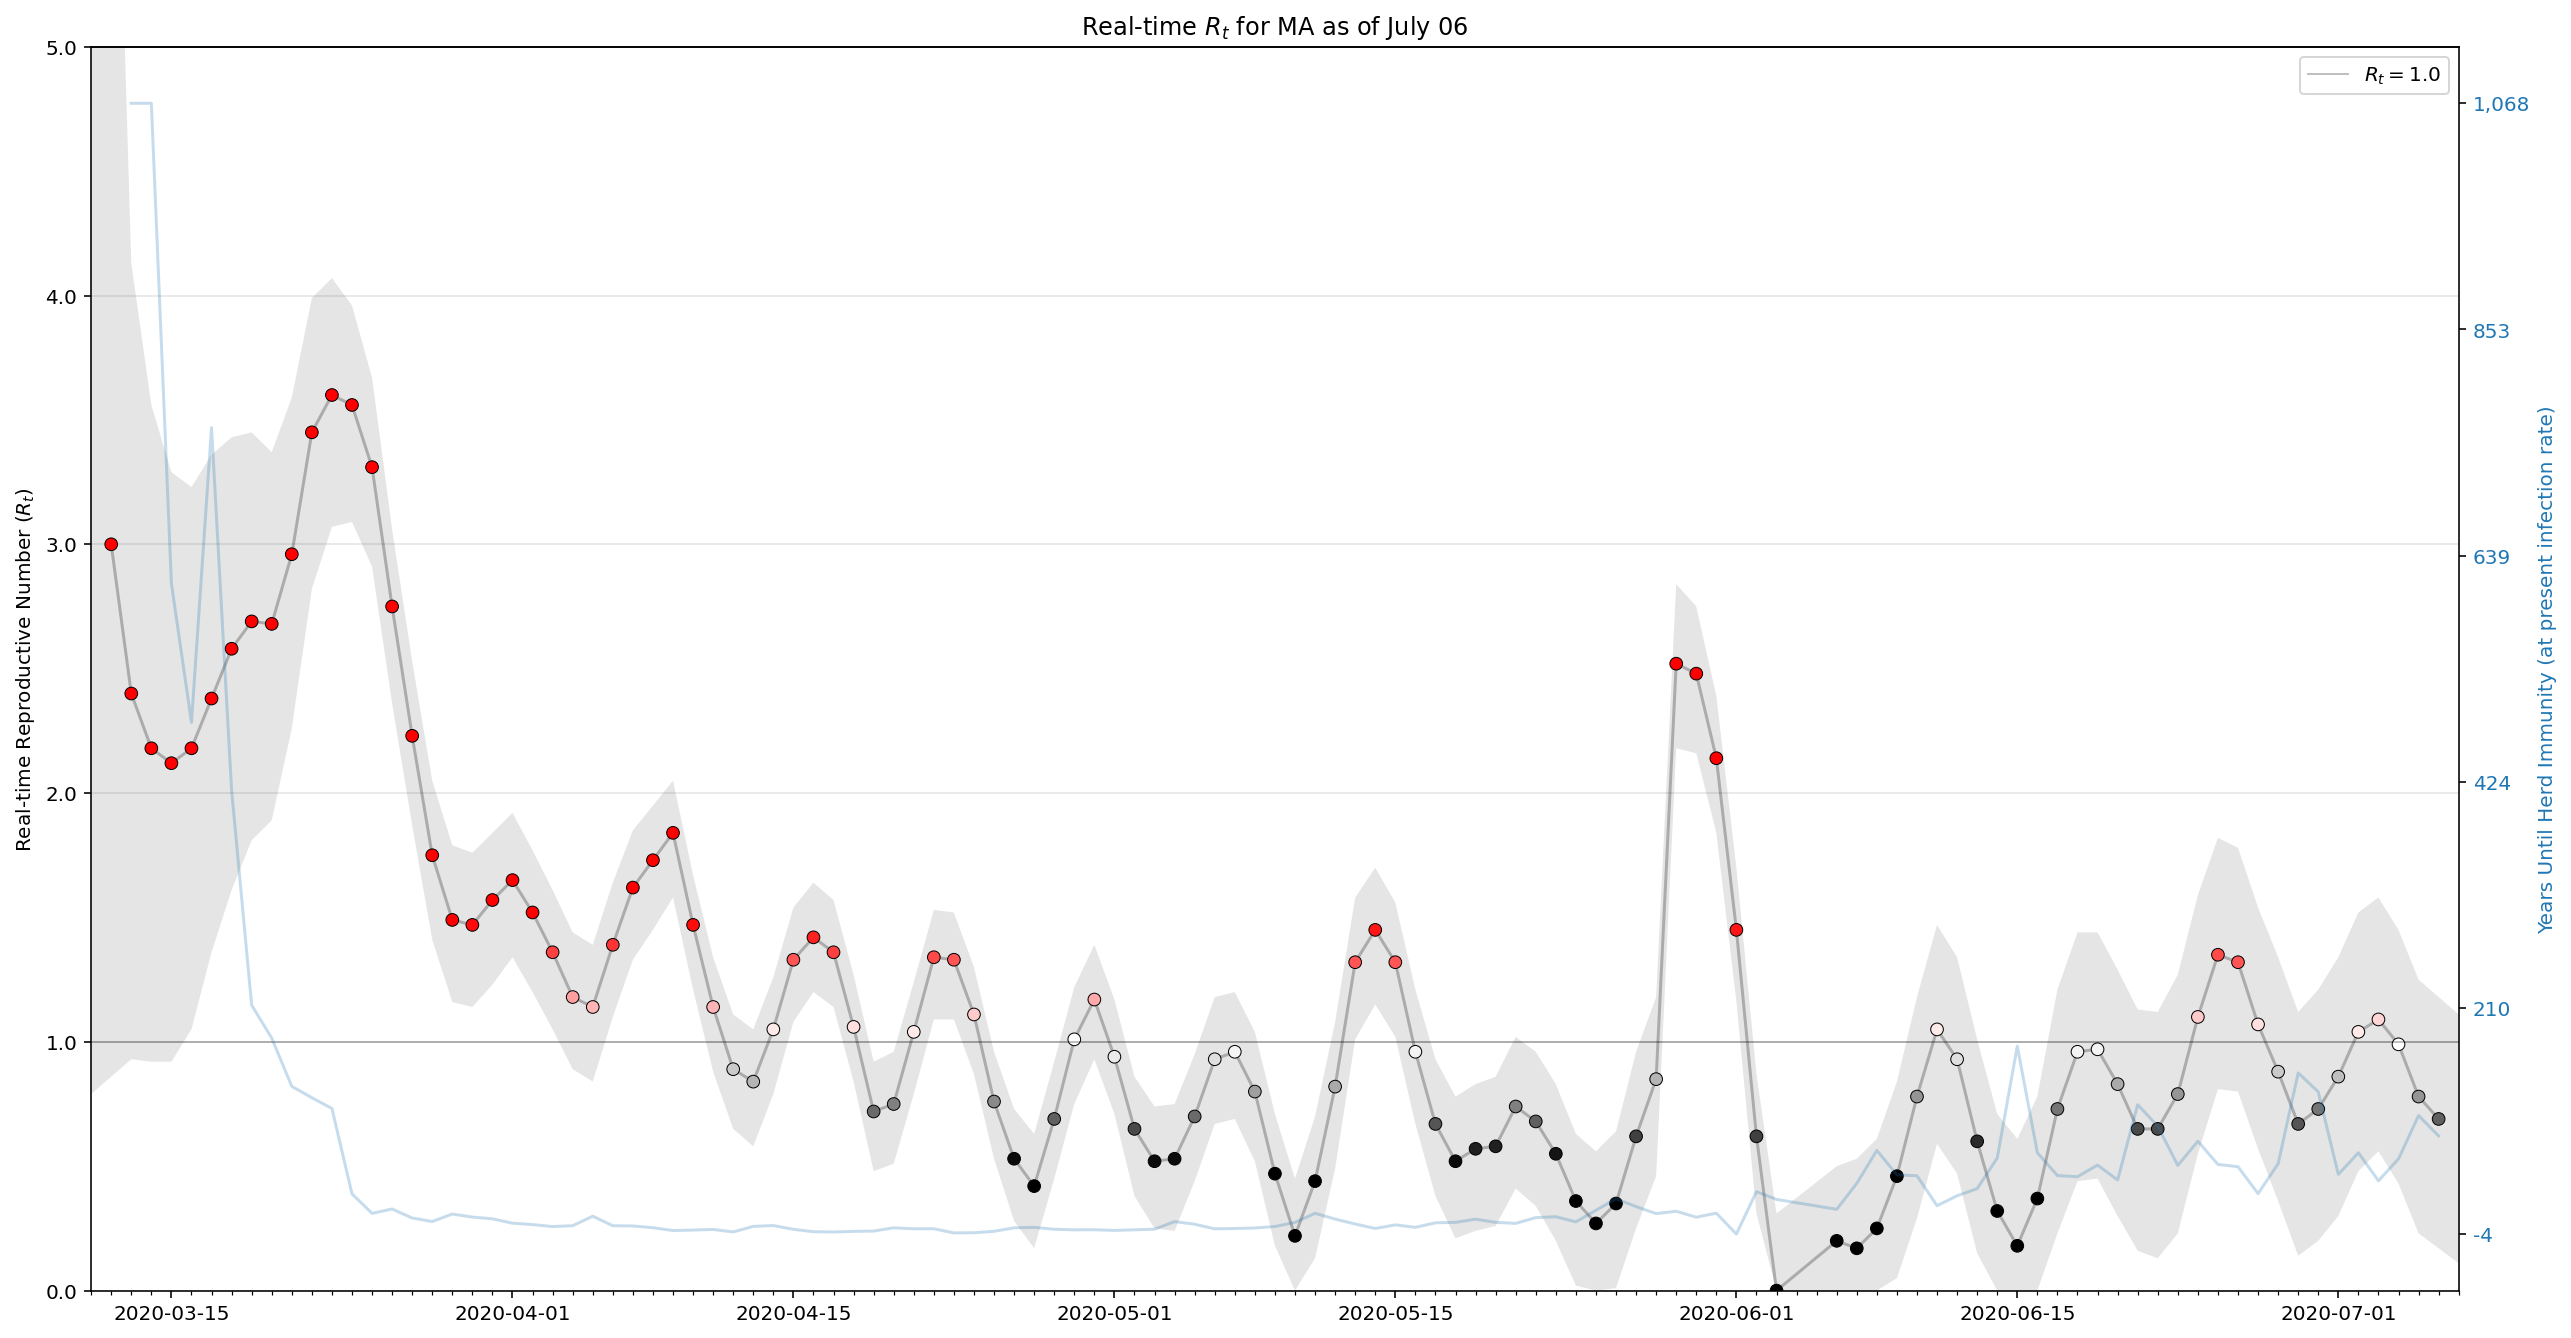

In [57]:

show_one_state('MA')

Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\pgf\Real_time_R_t_for_AZ_as_of_July.pgf
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\png\Real_time_R_t_for_AZ_as_of_July.png
Saving plot to D:\Documents\Repositories\notebooks\covid19\saves\svg\Real_time_R_t_for_AZ_as_of_July.svg


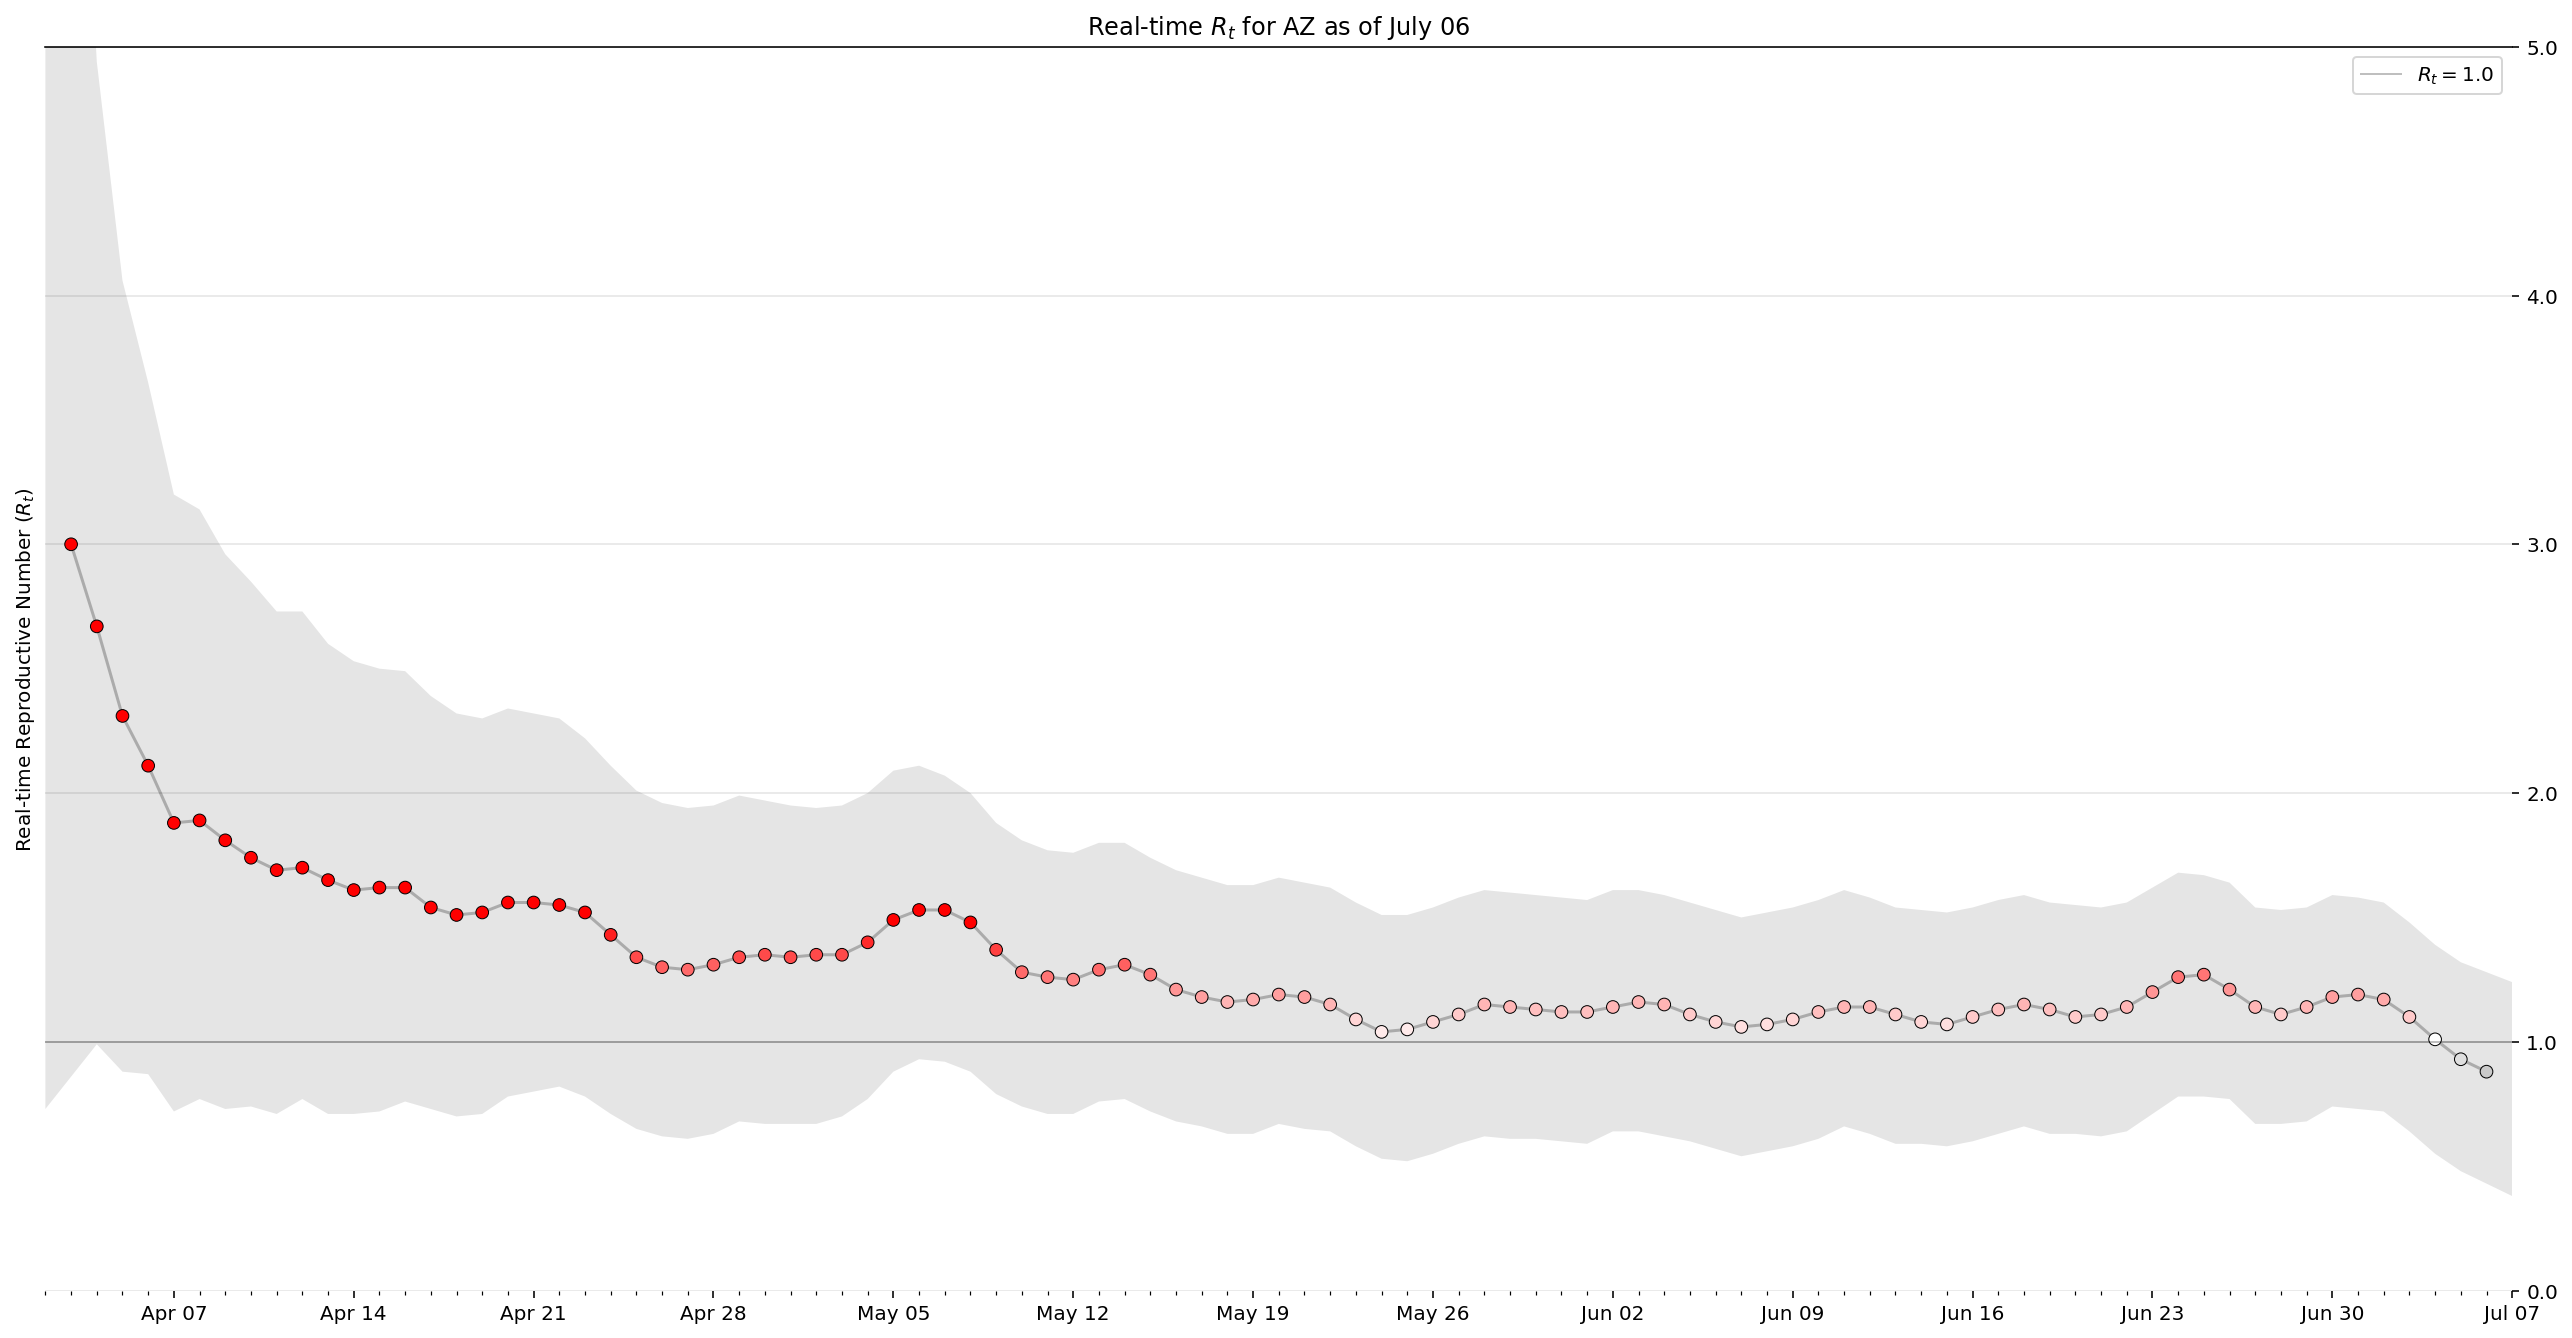

In [30]:

show_one_state('AZ')